# SN-GAN Training

This notebook demonstrates training a Spectral Normalization GAN (SN-GAN) on various datasets like shape3d, cars3d, dsprites 

The SN-GAN uses spectral normalization in the discriminator to control the Lipschitz constant, leading to more stable training compared to vanilla GANs.

In [1]:
import sys
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# Add the project root to the path to import our modules
sys.path.append('../../')

# Import our custom modules
from datasets.shapes3d import Shapes3D
from gan.trainer import GANTrainer
from gan.architecture import Generator, Discriminator
from gan.loss import get_loss

# Set up device and random seeds for reproducibility
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Set random seeds for reproducibility
seed_number = 42

torch.manual_seed(seed_number)
np.random.seed(seed_number)

random.seed(seed_number)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_number)
    torch.cuda.manual_seed_all(seed_number)

# For consistent results
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Shapes3d

In [3]:
# Dataset Configuration
print("Setting up Shapes3D dataset...")

# For this experiment, we'll allow all factors to vary
# This gives us the full diversity of the dataset
selected_factors = ['floorCol', 'wallCol', 'objCol', 'objSize', 'objType', 'objAzimuth']
not_selected_factors_index_value = {}  # Empty since we're selecting all factors
root = '/data/amin/shapes3d/'  # Adjust this path as needed


# Create dataset instance
dataset = Shapes3D(
    selected_factors=selected_factors,
    not_selected_factors_index_value=not_selected_factors_index_value,
    root=root,
)

print(f"Dataset loaded with {len(dataset)} images")
print(f"Image size: {dataset.img_size}")
print(f"Selected factors: {dataset.selected_factors}")

# Create DataLoader
batch_size = 64
dataloader = DataLoader(
    dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=7 if device.type == 'cuda' else 0,
    pin_memory=True if device.type == 'cuda' else False
)

print(f"DataLoader created with batch size: {batch_size}")
print(f"Number of batches: {len(dataloader)}")

Setting up Shapes3D dataset...
Dataset loaded with 480000 images
Image size: (3, 64, 64)
Selected factors: ['floorCol', 'wallCol', 'objCol', 'objSize', 'objType', 'objAzimuth']
DataLoader created with batch size: 64
Number of batches: 7500


Sample images from the Shapes3D dataset:


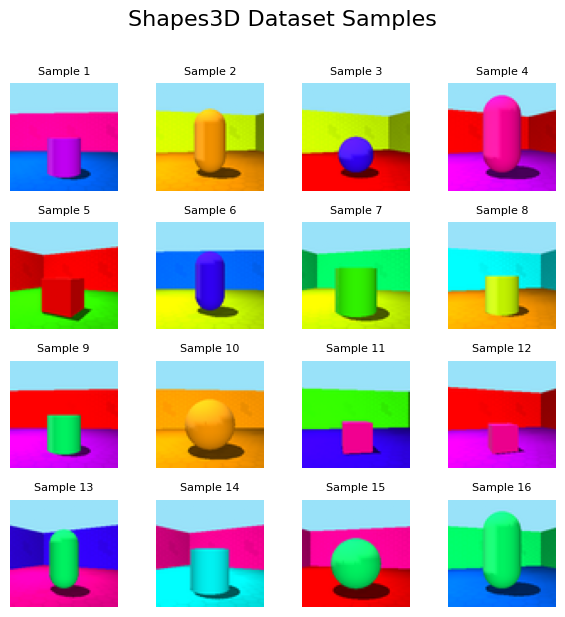

In [4]:
# Visualize some sample data
def show_data_samples(dataset, n_samples=16):
    """Display a grid of sample images from the dataset."""
    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    axes = axes.flatten()
    
    # Generate n_samples random indices
    indices = random.sample(range(len(dataset)), n_samples)
    
    for i, idx in enumerate(indices):
        img, factors = dataset[idx]
        
        # Convert from tensor to numpy and transpose for matplotlib
        img_np = img.permute(1, 2, 0).numpy()
        
        axes[i].imshow(img_np)
        axes[i].axis('off')
        axes[i].set_title(f'Sample {i+1}', fontsize=8)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the title
    fig.suptitle('Shapes3D Dataset Samples', fontsize=16, y=1.02, ha='center')  # Well aligned title
    plt.show()

print("Sample images from the Shapes3D dataset:")
show_data_samples(dataset)

In [5]:
# SN-GAN Configuration
print("Setting up SN-GAN trainer...")

# Model hyperparameters
latent_dim = 10
img_size = (3, 64, 64)  # C, H, W
learning_rate_g = 2e-4
learning_rate_d = 2e-4
beta1 = 0.0  # SN-GAN typically uses beta1=0
beta2 = 0.9

# Create SN-GAN trainer
# The 'sngan' loss type will automatically use spectral normalization in the discriminator
trainer = GANTrainer(
    generator=None,  # Will create default generator
    discriminator=None,  # Will create default discriminator with spectral norm
    loss_type='sngan',  # This uses hinge loss and spectral normalization
    loss_kwargs={},
    g_lr=learning_rate_g,
    d_lr=learning_rate_d,
    beta1=beta1,
    beta2=beta2,
    device=device,
    latent_dim=latent_dim,
    img_size=img_size,
    n_critic=1  # Update generator every discriminator update
)

print(f"SN-GAN trainer created")
print(f"Generator parameters: {sum(p.numel() for p in trainer.generator.parameters()):,}")
print(f"Discriminator parameters: {sum(p.numel() for p in trainer.discriminator.parameters()):,}")
print(f"Loss type: {trainer.loss_type}")
print(f"Device: {trainer.device}")

Setting up SN-GAN trainer...
SN-GAN trainer created
Generator parameters: 382,723
Discriminator parameters: 379,073
Loss type: sngan
Device: cuda


In [6]:
# Training Configuration
epochs = 5  # Adjust based on your computational resources
print(f"Starting SN-GAN training for {epochs} epochs...")

# Train the model
trainer.train(dataloader, epochs)

print("Training completed!")

Starting SN-GAN training for 5 epochs...
Starting training for 5 epochs...
Loss type: sngan
Device: cuda


Epoch 0: 100%|█████████████████████████████████████████████████████████████████████████| 7500/7500 [01:55<00:00, 65.00it/s, D_loss=0.7482, G_loss=0.8598]


Epoch [1/5] - D_loss: 1.0570, G_loss: 0.6691


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████| 7500/7500 [01:54<00:00, 65.35it/s, D_loss=0.8990, G_loss=0.7966]


Epoch [2/5] - D_loss: 0.8810, G_loss: 0.7747


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████| 7500/7500 [01:54<00:00, 65.31it/s, D_loss=0.9164, G_loss=0.7349]


Epoch [3/5] - D_loss: 0.9342, G_loss: 0.7076


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████| 7500/7500 [01:54<00:00, 65.29it/s, D_loss=0.9741, G_loss=0.6569]


Epoch [4/5] - D_loss: 0.9903, G_loss: 0.6503


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████| 7500/7500 [01:54<00:00, 65.34it/s, D_loss=0.9856, G_loss=0.6462]

Epoch [5/5] - D_loss: 1.0082, G_loss: 0.6300
Training completed!
Training completed!


Plotting training losses...


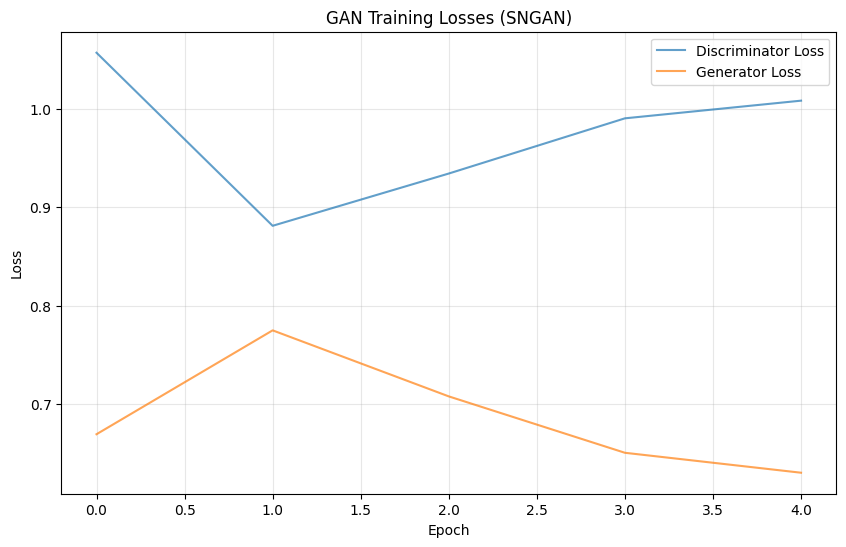


Training Summary:
Final Discriminator Loss: 1.0082
Final Generator Loss: 0.6300
Average Discriminator Loss: 0.9741
Average Generator Loss: 0.6864


In [7]:
# Visualize Training Progress
print("Plotting training losses...")
trainer.plot_losses()

# Show training history summary
if trainer.history['d_loss'] and trainer.history['g_loss']:
    print(f"\nTraining Summary:")
    print(f"Final Discriminator Loss: {trainer.history['d_loss'][-1]:.4f}")
    print(f"Final Generator Loss: {trainer.history['g_loss'][-1]:.4f}")
    print(f"Average Discriminator Loss: {np.mean(trainer.history['d_loss']):.4f}")
    print(f"Average Generator Loss: {np.mean(trainer.history['g_loss']):.4f}")

Generating sample images from trained SN-GAN...


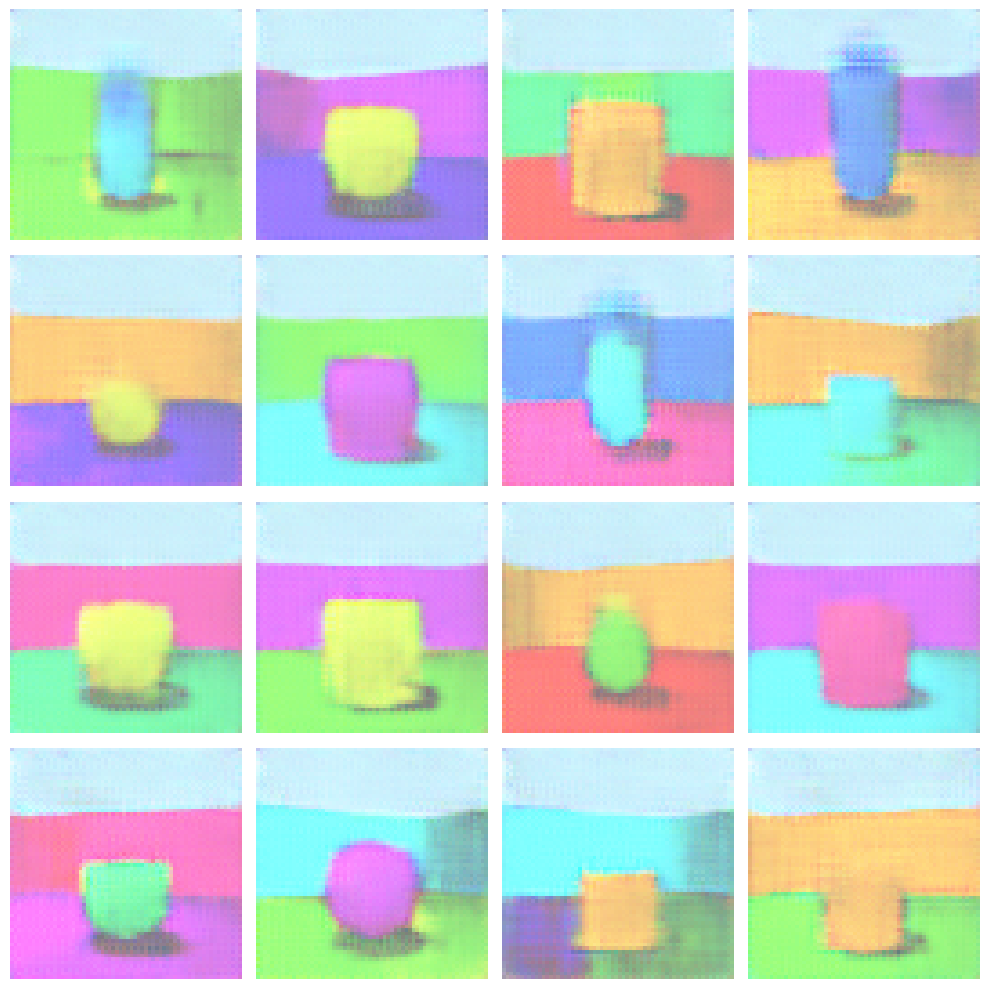


Generating additional samples...


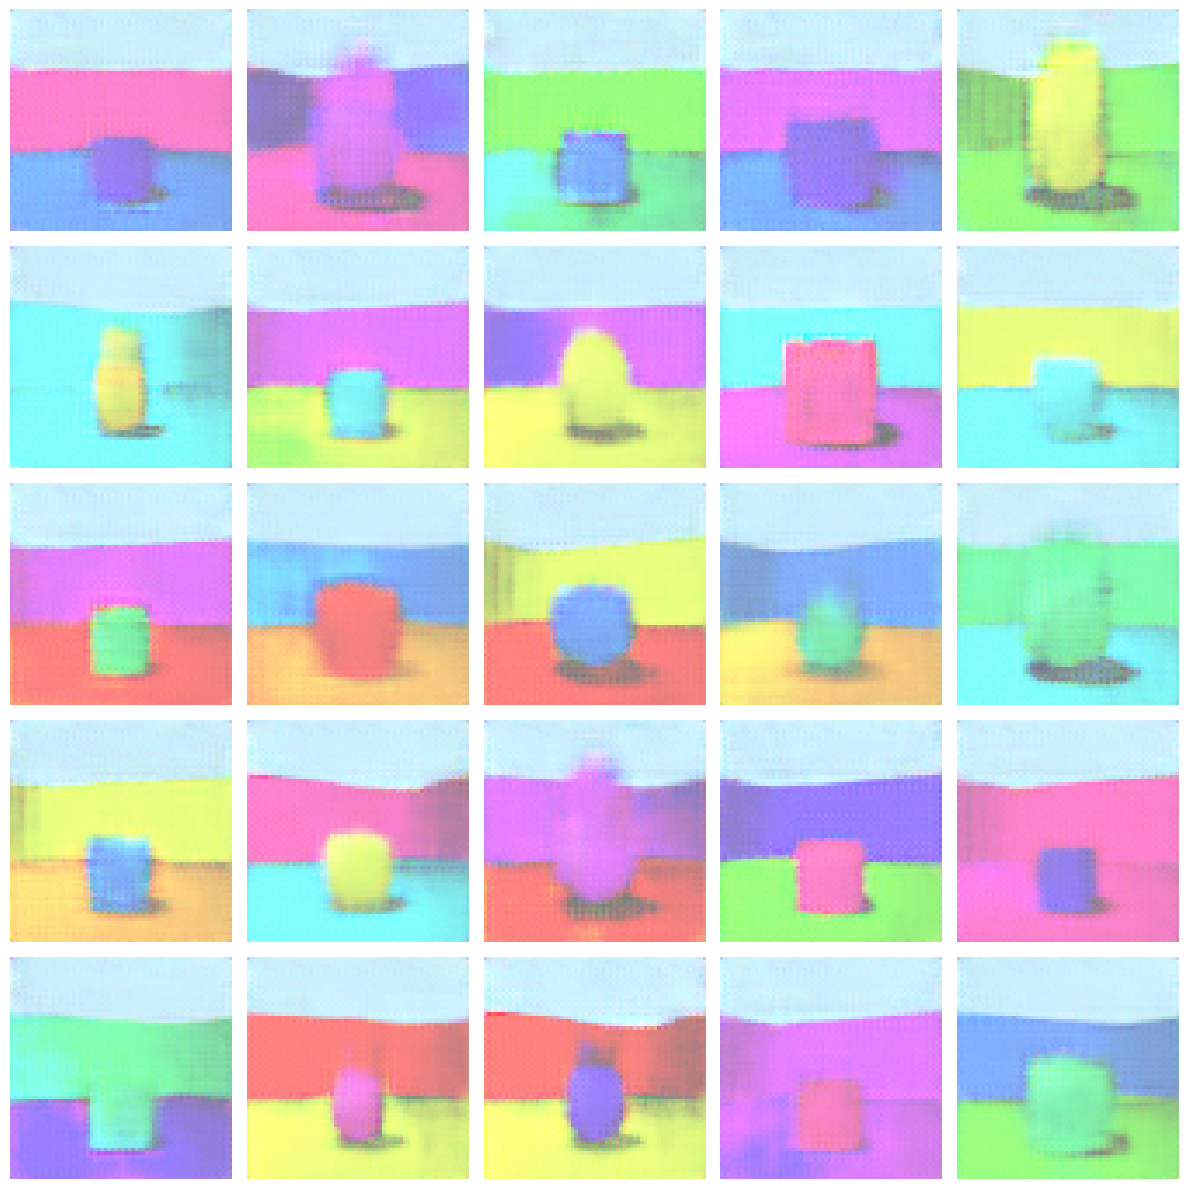

In [ ]:
# Generate and Display Sample Images
print("Generating sample images from trained SN-GAN...")
trainer.plot_samples(n_samples=25, n_cols=5, figsize=(12, 12))

# dsprites